In [1]:
from PIL import Image
import torch

In [2]:
import os
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### Load in Generator

In [4]:
import os
import torch
# Initalize original custom SG2-Ada generator
import pickle
os.chdir(f'{ROOT_PATH}/stylegan2-ada-pytorch/')
model_path = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/network-snapshot-001200.pkl"
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    G = architecture['G_ema'].to(device)

In [5]:
from glob import glob
import matplotlib.pyplot as plt
model_paths = glob("/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/PTI/experiments/checkpoints/*.pt")
e4e_images_paths = glob("/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Zalando_Germany_Dataset/dresses/images/pti_images/sample/*.jpg")

In [6]:
def compare_outputs(path):

    # Load PTI finetuned model
    G_PTI = torch.load(path, map_location=torch.device('cpu'))
    G_PTI = G_PTI.to(device)

    # Load corresponding latent embedding
    sku = path.split('/')[-1].split('_')[-1].split('.')[0]
    latent = torch.load(f"/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/PTI/experiments/embeddings/zalando_germany/PTI/{sku}/0.pt", map_location=torch.device('cpu'))
    latent = latent.to(device)

    #  Create image from finetuned-PTI model
    img = G_PTI.synthesis(latent, force_fp32=True)
    img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img_pti = Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')

    #  Create image from original SG2-Ada model
    img = G.synthesis(latent, force_fp32=True)
    img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img_sg2 = Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')

    # Load Original
    orig_path = [elem for elem in e4e_images_paths if sku in elem][0]
    img_orig = Image.open(orig_path)


    return img_pti, img_sg2, img_orig

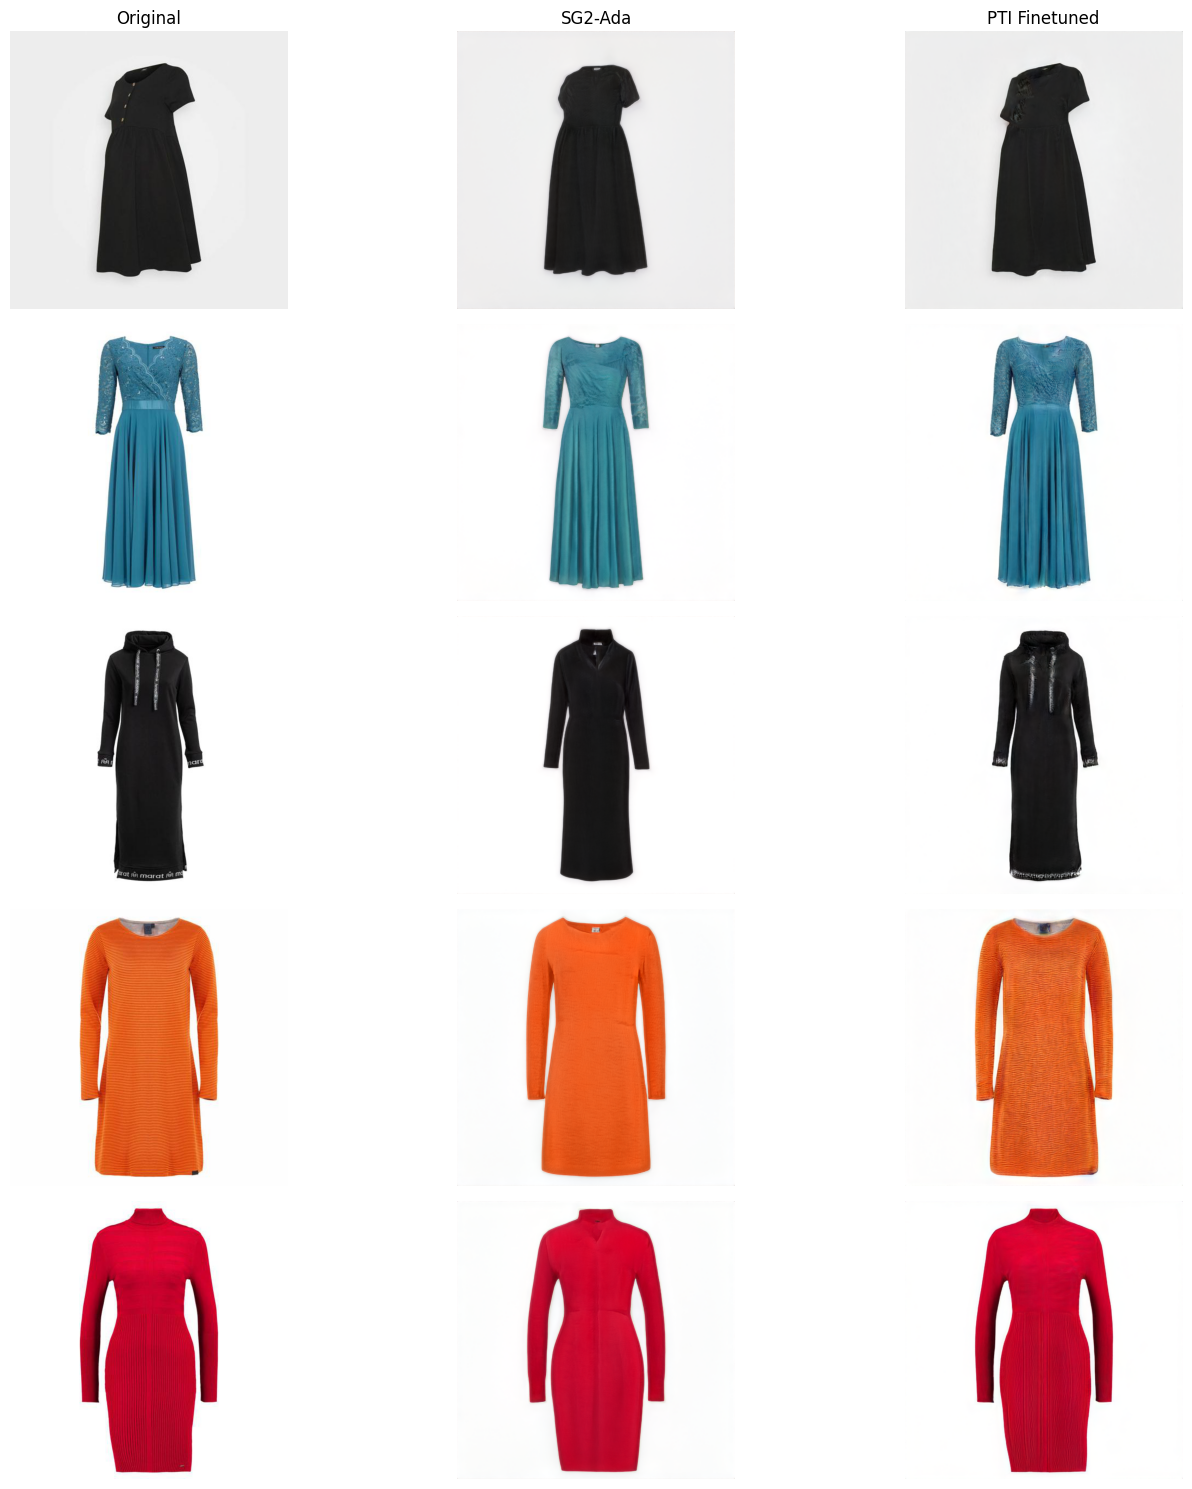

In [7]:
%matplotlib inline
fig, ax = plt.subplots(len(model_paths), 3, figsize = (15, len(model_paths)*3))

for i, path in enumerate(model_paths):
    img_pti, img_sg2 , img_orig = compare_outputs(path)
    ax[i,0].imshow(img_orig)
    ax[i,1].imshow(img_sg2)
    ax[i,2].imshow(img_pti)

    ax[i,0].axis('off')
    ax[i,1].axis('off')
    ax[i,2].axis('off')

    if i == 0:
        ax[i,0].set_title('Original')
        ax[i,1].set_title('SG2-Ada')
        ax[i,2].set_title('PTI Finetuned')

fig.tight_layout()
plt.show()